In [8]:
import pandas as pd
from IPython.core.display_functions import display
from catboost import CatBoostClassifier
from matplotlib import pyplot as plt
from sklearn import clone
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns

In [5]:
# Create a synthetic dataset
X, y = make_classification(
    n_samples=1000,  # Number of samples
    n_features=10,    # Number of features
    n_informative=2, # Number of informative features
    n_classes=2,     # Number of classes (binary classification)
    n_clusters_per_class=1,  # Number of clusters per class
    random_state=42  # Seed for reproducibility
)

# Create a DataFrame with feature names
feature_names = [f"feature_{i}" for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)

# Add the target variable to the DataFrame
df['target'] = y


In [6]:
df.head(2)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,target
0,1.376053,-1.607661,-0.835143,-0.319848,-0.936875,1.603393,0.568754,0.151758,0.184741,2.089539,0
1,-0.005795,1.671348,-0.176134,-0.893746,1.616256,-1.371212,-0.000382,-0.387965,-0.901376,-2.899514,1


In [9]:
train, valid = train_test_split(df, test_size=0.33, random_state=42)

In [13]:
def backward_elimination(train, valid, features, cat_features, target):
    stats = []

    eliminated_features = []
    best_ginis = []
    # backward elimination
    for iteration in tqdm(range(len(features) - 1)):
        print('Iteration number', iteration)
        best_gini = None
        worst_feature = None
        stat = {'iteration': iteration}
        for col in features:
            print('Feature ', col)
            if col in eliminated_features:
                continue

            X_train = train[sorted(set(features) - set(eliminated_features + [col]))]
            X_valid = valid[sorted(set(features) - set(eliminated_features + [col]))]

            model = CatBoostClassifier(verbose=0, eval_metric='AUC', early_stopping_rounds=60, random_state=42,
                                       cat_features=list(set(cat_features) & set(X_train.columns)))
            model.fit(X_train, train[target])
            valid_preds = model.predict_proba(X_valid)[:, 1]
            valid_gini = 2 * roc_auc_score(valid[target], valid_preds) - 1

            stat[col] = valid_gini

            if best_gini is None or best_gini < valid_gini:
                print('Best gini got worse: ', best_gini, valid_gini)
                best_gini = valid_gini
                worst_feature = col

        stats.append(stat)

        if best_gini:
            eliminated_features.append(worst_feature)
            best_ginis.append(best_gini)
            print('Features to eliminate:')
            print(eliminated_features)
            print('*'*10)
    stat_2 = pd.DataFrame(stats).T
    stat_2['cnt_nans'] = stat_2.isna().sum(axis=1).values

    stat_2 = stat_2.sort_values('cnt_nans', ascending=False).drop(columns=['cnt_nans'], index=['iteration'])
    display((stat_2 * 100).round(1))

    stat_1 = pd.DataFrame({'names': eliminated_features[::-1], 'ginis': best_ginis[::-1]})

    plt.figure(figsize=(16, 9))
    sns.lineplot(data=stat_1, x='names', y='ginis')
    plt.xticks(rotation=90)
    plt.show()

    num_features = stat_1['ginis'].argmax()
    best_gini = stat_1['ginis'].max()

    features_to_eliminate = stat_1['names'].iloc[num_features:]

    best_features = sorted(set(features) - set(features_to_eliminate))

    print('---' * 5, 'info', '---' * 5, sep='')
    print('Best ginis:', best_gini)
    print('Num features:', len(best_features))
    print('Best features:', ' '.join(best_features))
    print('---' * 12)

    best_model = clone(model)
    best_model.fit(train[best_features], train[target], cat_features=list(set(cat_features) & set(best_features)))

    return stat_1, stat_2, best_model

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

Iteration number 0
Feature  feature_0
Best gini got worse:  None 0.9781746031746033
Feature  feature_1
Best gini got worse:  0.9781746031746033 0.9784685479129922
Feature  feature_2
Feature  feature_3
Feature  feature_4
Feature  feature_5
Feature  feature_6
Best gini got worse:  0.9784685479129922 0.9792768959435627
Feature  feature_7
Feature  feature_8
Best gini got worse:  0.9792768959435627 0.9803791887125219
Feature  feature_9


 11%|█████████▎                                                                          | 1/9 [01:03<08:28, 63.60s/it]

Features to eliminate:
['feature_8']
**********
Iteration number 1
Feature  feature_0
Best gini got worse:  None 0.9796443268665491
Feature  feature_1
Best gini got worse:  0.9796443268665491 0.9822163433274547
Feature  feature_2
Feature  feature_3
Feature  feature_4
Feature  feature_5
Feature  feature_6
Feature  feature_7
Feature  feature_8
Feature  feature_9


 22%|██████████████████▋                                                                 | 2/9 [01:52<06:26, 55.23s/it]

Features to eliminate:
['feature_8', 'feature_1']
**********
Iteration number 2
Feature  feature_0
Best gini got worse:  None 0.9827307466196356
Feature  feature_1
Feature  feature_2
Feature  feature_3
Feature  feature_4
Feature  feature_5
Feature  feature_6
Feature  feature_7
Feature  feature_8
Feature  feature_9


 33%|████████████████████████████                                                        | 3/9 [02:35<04:57, 49.59s/it]

Best gini got worse:  0.9827307466196356 0.9829512051734275
Features to eliminate:
['feature_8', 'feature_1', 'feature_9']
**********
Iteration number 3
Feature  feature_0
Best gini got worse:  None 0.9828042328042328
Feature  feature_1
Feature  feature_2
Feature  feature_3
Best gini got worse:  0.9828042328042328 0.9836125808348029
Feature  feature_4
Feature  feature_5
Feature  feature_6
Feature  feature_7


 44%|█████████████████████████████████████▎                                              | 4/9 [03:12<03:41, 44.39s/it]

Feature  feature_8
Feature  feature_9
Features to eliminate:
['feature_8', 'feature_1', 'feature_9', 'feature_3']
**********
Iteration number 4
Feature  feature_0
Best gini got worse:  None 0.9833186360964139
Feature  feature_1
Feature  feature_2
Feature  feature_3
Feature  feature_4
Feature  feature_5
Feature  feature_6
Best gini got worse:  0.9833186360964139 0.9835390946502058
Feature  feature_7


 56%|██████████████████████████████████████████████▋                                     | 5/9 [03:44<02:39, 39.94s/it]

Best gini got worse:  0.9835390946502058 0.9837595532039978
Feature  feature_8
Feature  feature_9
Features to eliminate:
['feature_8', 'feature_1', 'feature_9', 'feature_3', 'feature_7']
**********
Iteration number 5
Feature  feature_0
Best gini got worse:  None 0.983833039388595
Feature  feature_1
Feature  feature_2
Feature  feature_3
Feature  feature_4
Feature  feature_5
Feature  feature_6


 67%|████████████████████████████████████████████████████████                            | 6/9 [04:10<01:45, 35.33s/it]

Feature  feature_7
Feature  feature_8
Feature  feature_9
Features to eliminate:
['feature_8', 'feature_1', 'feature_9', 'feature_3', 'feature_7', 'feature_0']
**********
Iteration number 6
Feature  feature_0
Feature  feature_1
Feature  feature_2
Best gini got worse:  None 0.9819958847736625
Feature  feature_3
Feature  feature_4
Feature  feature_5
Feature  feature_6


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [04:31<01:01, 30.71s/it]

Best gini got worse:  0.9819958847736625 0.9828042328042328
Feature  feature_7
Feature  feature_8
Feature  feature_9
Features to eliminate:
['feature_8', 'feature_1', 'feature_9', 'feature_3', 'feature_7', 'feature_0', 'feature_6']
**********
Iteration number 7
Feature  feature_0
Feature  feature_1
Feature  feature_2
Best gini got worse:  None 0.983906525573192
Feature  feature_3
Feature  feature_4
Feature  feature_5


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [04:47<00:25, 25.92s/it]

Feature  feature_6
Feature  feature_7
Feature  feature_8
Feature  feature_9
Features to eliminate:
['feature_8', 'feature_1', 'feature_9', 'feature_3', 'feature_7', 'feature_0', 'feature_6', 'feature_2']
**********
Iteration number 8
Feature  feature_0
Feature  feature_1
Feature  feature_2
Feature  feature_3
Feature  feature_4
Best gini got worse:  None 0.9115961199294531
Feature  feature_5


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [04:57<00:00, 33.02s/it]

Best gini got worse:  0.9115961199294531 0.9181731334509113
Feature  feature_6
Feature  feature_7
Feature  feature_8
Feature  feature_9
Features to eliminate:
['feature_8', 'feature_1', 'feature_9', 'feature_3', 'feature_7', 'feature_0', 'feature_6', 'feature_2', 'feature_5']
**********


,0,1,2,3,4,5,6,7,8
feature_8,98.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feature_1,97.8,98.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feature_9,97.9,98.1,98.3,NaN,NaN,NaN,NaN,NaN,NaN
feature_3,97.7,98.1,98.3,98.4,NaN,NaN,NaN,NaN,NaN
feature_7,97.6,97.7,97.9,98.1,98.4,NaN,NaN,NaN,NaN
feature_0,97.8,98.0,98.3,98.3,98.3,98.4,NaN,NaN,NaN
feature_6,97.9,98.1,98.2,98.2,98.4,98.3,98.3,NaN,NaN
feature_2,97.6,97.9,98.0,98.2,98.2,98.2,98.2,98.4,NaN
feature_4,97.3,97.6,97.6,97.8,98.0,98.1,98.2,92.8,91.2
feature_5,97.5,97.7,98.2,98.1,98.0,98.1,98.1,91.1,91.8


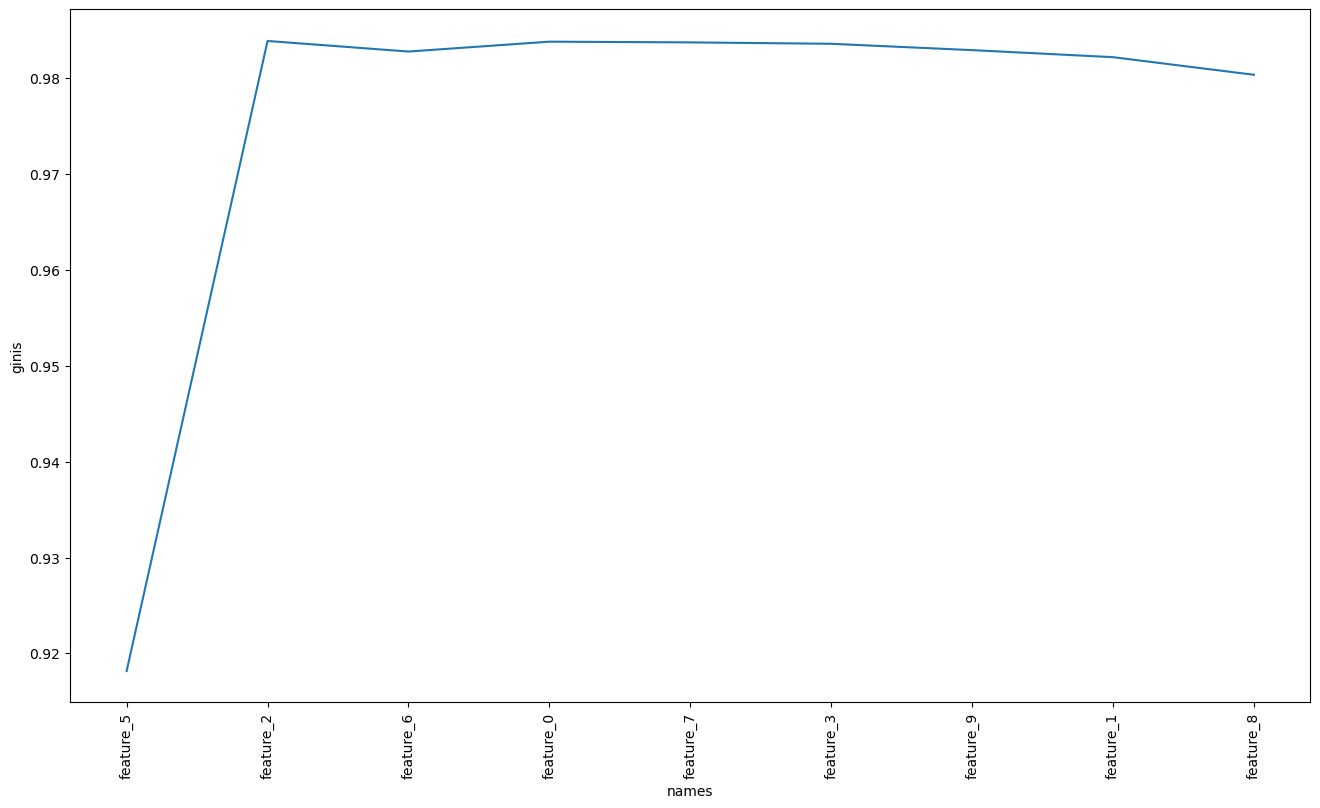

---------------info---------------
Best ginis: 0.983906525573192
Num features: 2
Best features: feature_4 feature_5
------------------------------------


In [14]:
s1,s2,best = backward_elimination(train,valid, train.columns[:-1], cat_features=[],target='target')